In [1]:
import pandas as pd
import re
import os
import glob
import snapatac2 as snap

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils
import subprocess

In [3]:
method = 'mementoht'

In [4]:
def merge_region(region='PFC',condition="MC",folder='/data2st1/junyi/output/atac0526/dar/region_nt/',method='mementob',blacklist=['Doublet','NN',"Neuron"]):
    df_result = pd.DataFrame()
    files = glob.glob(f'{folder}/{region}*{condition}_{method}.csv')
    for file in files:
        if any([file.find(black) > -1 for black in blacklist]):
            continue
        df_dar = pd.read_csv(file,index_col=0)

        ctname = file.split('/')[-1].replace('.csv', '')
        ctname = "_".join(ctname.split('_')[1:-2])
        if len(df_dar) == 0:
            continue
        df_dar['ctname'] = ctname
        df_result = pd.concat([df_result, df_dar], axis=0, ignore_index=True)
    df_result['region'] = region
    df_result['condition'] = condition
    return df_result


In [5]:
df_PFC_MC = merge_region(region='PFC',condition="MC",method=method)
df_PFC_MW = merge_region(region='PFC',condition="MW", method=method)
df_HIP_MC = merge_region(region='HIP',condition="MC",method=method)
df_HIP_MW = merge_region(region='HIP',condition="MW", method=method)
df_AMY_MC = merge_region(region='AMY',condition="MC",method=method)
df_AMY_MW = merge_region(region='AMY',condition="MW", method=method)
df_DAR_ALL = pd.concat([df_PFC_MC, df_PFC_MW, df_HIP_MC, df_HIP_MW, df_AMY_MC, df_AMY_MW], axis=0, ignore_index=True)

In [6]:
df_DAR_ALL = df_DAR_ALL[df_DAR_ALL.de_pval < 0.05]

In [7]:
df_DAR_ALL.rename(columns={'gene': 'names'}, inplace=True)

In [8]:
df_DAR_mememto = pd.concat([
    merge_region(region='PFC',condition="MC",method='mementob'),
    merge_region(region='PFC',condition="MW", method='mementob'),
    merge_region(region='HIP',condition="MC",method='mementob'),
    merge_region(region='HIP',condition="MW", method='mementob'),
    merge_region(region='AMY',condition="MC",method='mementob'),
    merge_region(region='AMY',condition="MW", method='mementob'),
    # merge_region(region='PFC',folder='/data2st1/junyi/output/atac0416/dar/celltype.L1/',condition="MC",method='mementob',blacklist=['Neuron']),
    # merge_region(region='PFC',folder='/data2st1/junyi/output/atac0416/dar/celltype.L1/',condition="MW", method='mementob',blacklist=['Neuron']),
    # merge_region(region='HIP',folder='/data2st1/junyi/output/atac0416/dar/celltype.L1/',condition="MC",method='mementob',blacklist=['Neuron']),
    # merge_region(region='HIP',folder='/data2st1/junyi/output/atac0416/dar/celltype.L1/',condition="MW", method='mementob',blacklist=['Neuron']),
    # merge_region(region='AMY',folder='/data2st1/junyi/output/atac0416/dar/celltype.L1/',condition="MC",method='mementob',blacklist=['Neuron']),
    # merge_region(region='AMY',folder='/data2st1/junyi/output/atac0416/dar/celltype.L1/',condition="MW", method='mementob',blacklist=['Neuron']),

], axis=0, ignore_index=True)


In [10]:
df_DAR_mememto

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition
0,chr2:98662628-98663129,stim,0.297648,0.040250,1.275518e-13,-0.126407,0.107848,0.234857,Immune,PFC,MC
1,chrX:143482812-143483313,stim,0.367096,0.049646,1.308574e-13,0.010504,0.125507,0.992527,Immune,PFC,MC
2,chr6:103648949-103649450,stim,0.297753,0.040198,1.474284e-13,-0.144116,0.094564,0.110749,Immune,PFC,MC
3,chr2:98662045-98662546,stim,0.314090,0.042905,2.253055e-13,-0.469675,0.251926,0.074096,Immune,PFC,MC
4,chr12:20815539-20816040,stim,0.679751,0.098147,5.078591e-12,-0.045391,0.226588,0.728508,Immune,PFC,MC
...,...,...,...,...,...,...,...,...,...,...,...
448926,chr11:77216664-77217165,stim,-0.000841,0.065789,9.991364e-01,0.021796,0.220886,0.960574,AMY_GABA,AMY,MW
448927,chr4:105109646-105110147,stim,-0.001628,0.045291,9.994340e-01,-0.274336,0.179532,0.108670,AMY_GABA,AMY,MW
448928,chr2:5411613-5412114,stim,-0.002643,0.054397,9.995078e-01,-0.014864,0.178744,0.904025,AMY_GABA,AMY,MW
448929,chr7:44442313-44442814,stim,-0.000612,0.066298,9.997550e-01,-0.025902,0.186608,0.892611,AMY_GABA,AMY,MW


In [11]:
df_DAR_mememto.rename(columns={'gene': 'names'}, inplace=True)

In [12]:
df_inner=df_DAR_ALL.merge(
    df_DAR_mememto[['names', 'ctname', 'region', 'condition']],
    how='inner',
    left_on=['names', 'ctname', 'region', 'condition'],
    right_on=['names', 'ctname', 'region', 'condition'],
)

In [13]:
df_DAR_ALL.groupby(['ctname','condition','region']).size().reset_index(name='counts')

,ctname,condition,region,counts
0,AMY_GABA,MC,AMY,6804
1,AMY_GABA,MW,AMY,710
2,AMY_Glut,MC,AMY,5384
3,AMY_Glut,MW,AMY,8968
4,Astro-Epen,MC,AMY,1369
5,Astro-Epen,MC,HIP,5204
6,Astro-Epen,MC,PFC,168
7,Astro-Epen,MW,AMY,584
8,Astro-Epen,MW,HIP,231
9,Astro-Epen,MW,PFC,12546


In [14]:
df_DAR_mememto.groupby(['ctname','condition','region']).size().reset_index(name='counts')

,ctname,condition,region,counts
0,AMY_GABA,MC,AMY,21148
1,AMY_GABA,MW,AMY,8383
2,AMY_Glut,MC,AMY,18187
3,AMY_Glut,MW,AMY,23868
4,Astro-Epen,MC,AMY,12949
5,Astro-Epen,MC,HIP,16778
6,Astro-Epen,MC,PFC,3039
7,Astro-Epen,MW,AMY,10389
8,Astro-Epen,MW,HIP,4747
9,Astro-Epen,MW,PFC,25027


In [15]:
df_inner.groupby(['ctname','condition','region']).size().reset_index(name='counts')

,ctname,condition,region,counts
0,AMY_GABA,MC,AMY,6804
1,AMY_GABA,MW,AMY,710
2,AMY_Glut,MC,AMY,5384
3,AMY_Glut,MW,AMY,8968
4,Astro-Epen,MC,AMY,1369
5,Astro-Epen,MC,HIP,5204
6,Astro-Epen,MC,PFC,168
7,Astro-Epen,MW,AMY,584
8,Astro-Epen,MW,HIP,231
9,Astro-Epen,MW,PFC,12546


In [16]:
df_annotattion = utils.annotate_region(df_DAR_ALL,region_col='names', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')

In [17]:
df_annotattion

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance
0,chr2:98662045-98662546,stim,0.339780,0.039203,5.092569e-18,-0.439839,0.210837,0.032661,Immune,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0
1,chr2:98662628-98663129,stim,0.304845,0.039133,5.875990e-15,-0.182576,0.108149,0.097428,Immune,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0
2,chr19:40723493-40723994,stim,0.315627,0.040977,1.322389e-14,-0.002205,0.142656,0.969473,Immune,PFC,MC,Entpd1,ENSMUSG00000048120.16,40612365,40741602,+,genebody,0
3,chrX:143482812-143483313,stim,0.368187,0.050381,3.022079e-13,-0.068437,0.117317,0.541328,Immune,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278
4,chr6:103648949-103649450,stim,0.292500,0.040483,4.829835e-13,-0.302528,0.083680,0.000290,Immune,PFC,MC,Chl1,ENSMUSG00000030077.11,103510585,103750211,+,genebody,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150026,chr2:84670518-84671019,stim,-0.287196,0.146784,4.927242e-02,0.633020,0.441848,0.196911,Astro-Epen,AMY,MW,Gm28635,ENSMUSG00000101645.1,84601438,84678041,-,genebody,0
150027,chr15:57695402-57695903,stim,-0.240560,0.122659,4.931403e-02,-0.020377,0.447583,0.932987,Astro-Epen,AMY,MW,Zhx2,ENSMUSG00000071757.10,57694664,57839832,+,genebody,0
150028,chr7:44854318-44854819,stim,-0.226488,0.115238,4.954609e-02,0.148707,0.325551,0.695265,Astro-Epen,AMY,MW,Akt1s1,ENSMUSG00000011096.17,44848990,44855421,+,genebody,0
150029,chr7:81523209-81523710,stim,-0.211115,0.107507,4.991111e-02,0.138070,0.331986,0.704509,Astro-Epen,AMY,MW,2900076A07Rik,ENSMUSG00000097277.7,81523549,81531498,+,genebody,0


In [ ]:
#df_annotattion.to_csv(f'/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_{method}.csv',index=False)

PermissionError: [Errno 13] Permission denied: '/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_mementoht.csv'

In [19]:
df_annotattion_inner =utils.annotate_region(df_inner,region_col='names', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')

In [ ]:
#df_annotattion_inner.to_csv(f'/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_inner.csv',index=False)

In [20]:
df_counts = df_DAR_ALL.groupby(['ctname','condition','region']).size().reset_index(name='counts')

In [21]:
df_counts.sort_values(by=['region','condition','counts'])

,ctname,condition,region,counts
4,Astro-Epen,MC,AMY,1369
20,OPC-Oligo,MC,AMY,1708
14,Immune,MC,AMY,4903
2,AMY_Glut,MC,AMY,5384
0,AMY_GABA,MC,AMY,6804
17,Immune,MW,AMY,302
23,OPC-Oligo,MW,AMY,572
7,Astro-Epen,MW,AMY,584
1,AMY_GABA,MW,AMY,710
3,AMY_Glut,MW,AMY,8968


/tmp/ipykernel_1058057/826554249.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_counts, y='ctname', x='counts', hue='condition', palette=['#FF7F0E','#1F77B4'], dodge=True,ci=None)


<Axes: xlabel='counts', ylabel='ctname'>

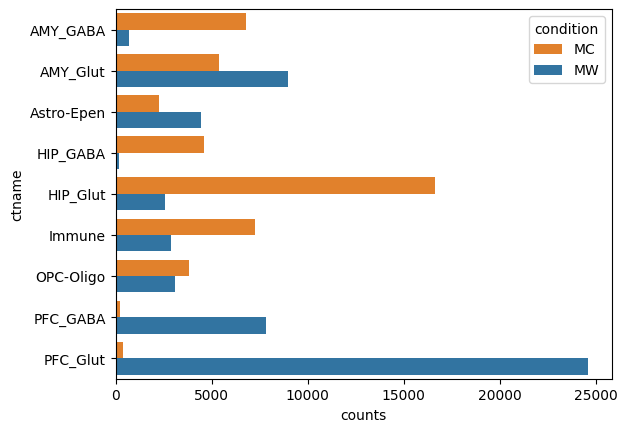

In [23]:
sns.barplot(data=df_counts, y='ctname', x='counts', hue='condition', palette=['#FF7F0E','#1F77B4'], dodge=True,ci=None)
#plt.xlim(0, 5000)

/tmp/ipykernel_1058057/3047026108.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(x="condition",y='counts', hue="condition",estimator='sum',ci=None, col="region",order=['MW','MC'],hue_order=['MC','MW'], data=df_counts, kind="bar", height=4, aspect=1.5,sharey=False)


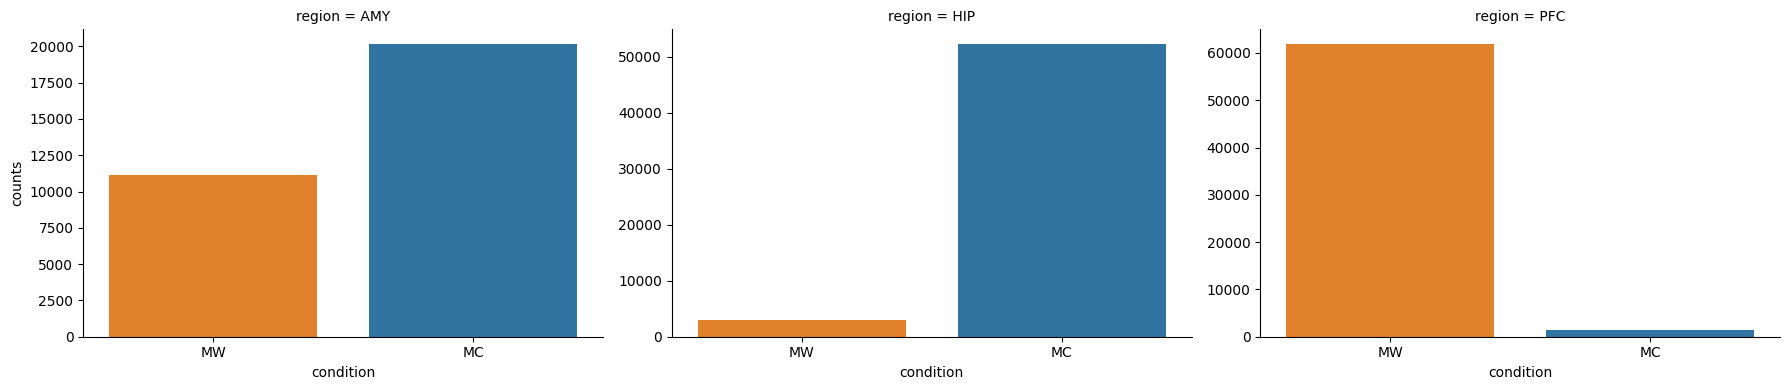

In [24]:
sns.catplot(x="condition",y='counts', hue="condition",estimator='sum',ci=None, col="region",order=['MW','MC'],hue_order=['MC','MW'], data=df_counts, kind="bar", height=4, aspect=1.5,sharey=False)

In [ ]:
folder_me = '/data2st1/junyi/output/atac0416/dar/celltype.L2/'
df_DAR_mememto_l2 = pd.concat([
    merge_region(region='PFC',condition="MC",method='mementob',folder=folder_me),
    merge_region(region='PFC',condition="MW", method='mementob',folder=folder_me),
    merge_region(region='HIP',condition="MC",method='mementob',folder=folder_me),
    merge_region(region='HIP',condition="MW", method='mementob',folder=folder_me),
    merge_region(region='AMY',condition="MC",method='mementob',folder=folder_me),
    merge_region(region='AMY',condition="MW", method='mementob',folder=folder_me),
], axis=0, ignore_index=True)


In [ ]:
folder_me = '/data2st1/junyi/output/atac0416/dar/celltype.L2/'
df_DAR_wicoxon_l2 = pd.concat([
    merge_region(region='PFC',condition="MC",method='wilcoxon',folder=folder_me),
    merge_region(region='PFC',condition="MW", method='wilcoxon',folder=folder_me),
    merge_region(region='HIP',condition="MC",method='wilcoxon',folder=folder_me),
    merge_region(region='HIP',condition="MW", method='wilcoxon',folder=folder_me),
    merge_region(region='AMY',condition="MC",method='wilcoxon',folder=folder_me),
    merge_region(region='AMY',condition="MW", method='wilcoxon',folder=folder_me),
], axis=0, ignore_index=True)


In [ ]:
sns.countplot(data=df_DAR_wicoxon_l2, y='ctname', hue='condition', palette=['#FF7F0E','#1F77B4'],hue_order=['MW','MC'])
plt.xlim(0, 5000)

In [ ]:
sns.countplot(data=df_DAR_mememto, y='ctname', hue='condition', palette=['#FF7F0E','#1F77B4'],hue_order=['MW','MC'])

In [ ]:
sns.countplot(data=df_DAR_ALL, y='ctname', hue='condition', palette=['#FF7F0E','#1F77B4'],hue_order=['MW','MC'])
plt.xlim(0, 5000)

In [ ]:
plt.figure(figsize=(10, 10))
sns.countplot(data=df_DAR_mememto_l2, y='ctname', hue='condition', palette=['#FF7F0E','#1F77B4'],hue_order=['MW','MC'])

In [ ]:
df_DAR_mememto

In [26]:
df_annotattion_mememto = utils.annotate_region(df_DAR_mememto,region_col='names', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')

In [27]:
df_annotattion_mememto

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance
0,chr2:98662628-98663129,stim,0.297648,0.040250,1.275518e-13,-0.126407,0.107848,0.234857,Immune,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0
1,chrX:143482812-143483313,stim,0.367096,0.049646,1.308574e-13,0.010504,0.125507,0.992527,Immune,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278
2,chr6:103648949-103649450,stim,0.297753,0.040198,1.474284e-13,-0.144116,0.094564,0.110749,Immune,PFC,MC,Chl1,ENSMUSG00000030077.11,103510585,103750211,+,genebody,0
3,chr2:98662045-98662546,stim,0.314090,0.042905,2.253055e-13,-0.469675,0.251926,0.074096,Immune,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0
4,chr12:20815539-20816040,stim,0.679751,0.098147,5.078591e-12,-0.045391,0.226588,0.728508,Immune,PFC,MC,1700030C10Rik,ENSMUSG00000099759.1,20804380,20815779,-,genebody,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448926,chr11:77216664-77217165,stim,-0.000841,0.065789,9.991364e-01,0.021796,0.220886,0.960574,AMY_GABA,AMY,MW,Ssh2,ENSMUSG00000037926.15,77216286,77460220,+,genebody,0
448927,chr4:105109646-105110147,stim,-0.001628,0.045291,9.994340e-01,-0.274336,0.179532,0.108670,AMY_GABA,AMY,MW,Prkaa2,ENSMUSG00000028518.8,105029873,105109890,-,genebody,0
448928,chr2:5411613-5412114,stim,-0.002643,0.054397,9.995078e-01,-0.014864,0.178744,0.904025,AMY_GABA,AMY,MW,Camk1d,ENSMUSG00000039145.16,5293456,5714515,-,genebody,0
448929,chr7:44442313-44442814,stim,-0.000612,0.066298,9.997550e-01,-0.025902,0.186608,0.892611,AMY_GABA,AMY,MW,Lrrc4b,ENSMUSG00000047085.14,44429017,44463351,+,genebody,0


In [28]:
from statsmodels.stats.multitest import multipletests
rejected, adjusted_pvals, _, _ = multipletests(df_DAR_mememto.de_pval, method='fdr_bh')


In [29]:
df_annotattion_mememto['de_pval_adj'] = adjusted_pvals

In [30]:
df_annotattion_mememto

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene_name,gene_id,gstart,gend,strand,annotation,distance,de_pval_adj
0,chr2:98662628-98663129,stim,0.297648,0.040250,1.275518e-13,-0.126407,0.107848,0.234857,Immune,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,3.038415e-12
1,chrX:143482812-143483313,stim,0.367096,0.049646,1.308574e-13,0.010504,0.125507,0.992527,Immune,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278,3.114843e-12
2,chr6:103648949-103649450,stim,0.297753,0.040198,1.474284e-13,-0.144116,0.094564,0.110749,Immune,PFC,MC,Chl1,ENSMUSG00000030077.11,103510585,103750211,+,genebody,0,3.496496e-12
3,chr2:98662045-98662546,stim,0.314090,0.042905,2.253055e-13,-0.469675,0.251926,0.074096,Immune,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0,5.274371e-12
4,chr12:20815539-20816040,stim,0.679751,0.098147,5.078591e-12,-0.045391,0.226588,0.728508,Immune,PFC,MC,1700030C10Rik,ENSMUSG00000099759.1,20804380,20815779,-,genebody,0,1.072659e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448926,chr11:77216664-77217165,stim,-0.000841,0.065789,9.991364e-01,0.021796,0.220886,0.960574,AMY_GABA,AMY,MW,Ssh2,ENSMUSG00000037926.15,77216286,77460220,+,genebody,0,9.995673e-01
448927,chr4:105109646-105110147,stim,-0.001628,0.045291,9.994340e-01,-0.274336,0.179532,0.108670,AMY_GABA,AMY,MW,Prkaa2,ENSMUSG00000028518.8,105029873,105109890,-,genebody,0,9.997094e-01
448928,chr2:5411613-5412114,stim,-0.002643,0.054397,9.995078e-01,-0.014864,0.178744,0.904025,AMY_GABA,AMY,MW,Camk1d,ENSMUSG00000039145.16,5293456,5714515,-,genebody,0,9.997351e-01
448929,chr7:44442313-44442814,stim,-0.000612,0.066298,9.997550e-01,-0.025902,0.186608,0.892611,AMY_GABA,AMY,MW,Lrrc4b,ENSMUSG00000047085.14,44429017,44463351,+,genebody,0,9.998449e-01


In [31]:
df_annotattion_mememto.rename(columns={'gene_name': 'gene'}, inplace=True)

In [ ]:
#df_annotattion_mememto.to_csv(f'/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_mememto.csv',index=False)

In [32]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)

In [33]:
df_deg_select = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]

In [34]:
df_deg_select['condition'] = 'MW'
df_deg_select.loc[df_deg_select.de_coef>0,'condition'] = 'MC'

/tmp/ipykernel_1058057/3437822688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deg_select['condition'] = 'MW'


In [35]:
df_DAR_ALL

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition
0,chr2:98662045-98662546,stim,0.339780,0.039203,5.092569e-18,-0.439839,0.210837,0.032661,Immune,PFC,MC
1,chr2:98662628-98663129,stim,0.304845,0.039133,5.875990e-15,-0.182576,0.108149,0.097428,Immune,PFC,MC
2,chr19:40723493-40723994,stim,0.315627,0.040977,1.322389e-14,-0.002205,0.142656,0.969473,Immune,PFC,MC
3,chrX:143482812-143483313,stim,0.368187,0.050381,3.022079e-13,-0.068437,0.117317,0.541328,Immune,PFC,MC
4,chr6:103648949-103649450,stim,0.292500,0.040483,4.829835e-13,-0.302528,0.083680,0.000290,Immune,PFC,MC
...,...,...,...,...,...,...,...,...,...,...,...
397804,chr2:84670518-84671019,stim,-0.287196,0.146784,4.927242e-02,0.633020,0.441848,0.196911,Astro-Epen,AMY,MW
397805,chr15:57695402-57695903,stim,-0.240560,0.122659,4.931403e-02,-0.020377,0.447583,0.932987,Astro-Epen,AMY,MW
397806,chr7:44854318-44854819,stim,-0.226488,0.115238,4.954609e-02,0.148707,0.325551,0.695265,Astro-Epen,AMY,MW
397807,chr7:81523209-81523710,stim,-0.211115,0.107507,4.991111e-02,0.138070,0.331986,0.704509,Astro-Epen,AMY,MW


In [36]:
df_annotattion_mememtoht = utils.annotate_region(df_DAR_ALL, region_col='names', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')

In [37]:
df_annotattion_mememtoht.rename(columns={'gene_name': 'gene'}, inplace=True)

In [38]:
df_deg_select.groupby(['ctname','condition']).size().reset_index(name='counts')

,ctname,condition,counts
0,AMY_GABA,MC,5572
1,AMY_GABA,MW,657
2,AMY_Glut,MC,6391
3,AMY_Glut,MW,998
4,HIP_GABA,MC,3281
5,HIP_GABA,MW,377
6,HIP_Glut,MC,2148
7,HIP_Glut,MW,2886
8,PFC_GABA,MC,2985
9,PFC_GABA,MW,692


In [39]:
len(df_deg_select)

32181

In [40]:
len(df_annotattion_mememto.drop_duplicates(subset=['gene']))

25032

In [41]:
len(df_annotattion_mememtoht.drop_duplicates(subset=['gene']))

20247

In [42]:
df_degdar = df_annotattion_mememto.merge(df_deg_select,how='inner',left_on=['ctname','condition','gene'],right_on=['ctname','condition','gene'],suffixes=('_atac', '_sc'))

In [43]:
df_degdar_ht = df_annotattion_mememtoht.merge(df_deg_select,how='inner',left_on=['ctname','condition','gene'],right_on=['ctname','condition','gene'],suffixes=('_atac', '_sc'))

In [54]:
df_wil = pd.read_csv('/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv')

In [57]:
df_wil.rename(columns={'gene_name': 'gene'}, inplace=True)

In [58]:
d_degdar_wil = df_wil.merge(df_deg_select,how='inner',left_on=['ctname','condition','gene'],right_on=['ctname','condition','gene'],suffixes=('_atac', '_sc'))

In [59]:
d_degdar_wil.sort_values(by='condition', ascending=False, inplace=True)

In [60]:
d_degdar_wil.loc[d_degdar_wil.condition=='MW','logfoldchanges'] = d_degdar_wil.loc[d_degdar_wil.condition=='MW','logfoldchanges']*-1

In [61]:
for ctname in d_degdar_wil.ctname.unique():
    df_ct = d_degdar_wil[d_degdar_wil.ctname == ctname]
    corr = df_ct[['logfoldchanges', 'de_coef']].corr().iloc[0, 1]
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct)}')

Correlation for PFC_Glut: 0.04,size=6834
Correlation for PFC_GABA: 0.45,size=72
Correlation for AMY_Glut: 0.52,size=143
Correlation for HIP_Glut: -0.06,size=1466
Correlation for AMY_GABA: 0.03,size=185
Correlation for HIP_GABA: nan,size=1


In [80]:
len(set(df_degdar_ht.gene).union(set(df_deg.gene)))

11634

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_pval_adj,gender,region,ctname
0,Xkr4,stim,-0.021793,0.008108,4.471005e-03,0.035998,0.020242,0.037788,7.010951e-03,F,AMY,AMY_Glut
1,Gm1992,stim,0.130808,0.013995,4.154986e-16,0.084202,0.040413,0.021634,1.643341e-15,F,AMY,AMY_Glut
2,Gm19938,stim,-0.026062,0.015862,5.941634e-02,-0.061701,0.048011,0.173329,7.898525e-02,F,AMY,AMY_Glut
3,Mrpl15,stim,0.150841,0.029090,5.797483e-06,-0.036198,0.083939,0.435711,1.223319e-05,F,AMY,AMY_Glut
4,Lypla1,stim,-0.000161,0.025848,8.359414e-01,-0.057159,0.067307,0.391527,8.616019e-01,F,AMY,AMY_Glut
...,...,...,...,...,...,...,...,...,...,...,...,...
275427,mt-Nd4,stim,0.124866,0.077244,7.734766e-02,1.171788,0.250023,0.000002,8.927336e-02,M,TH,TH_GABA
275428,mt-Cytb,stim,-0.226486,0.076847,4.411676e-03,0.869196,0.230249,0.000120,5.730250e-03,M,TH,TH_GABA
275429,CAAA01118383.1,stim,-0.125739,0.085886,1.145203e-01,-0.053768,0.148396,0.620622,1.295853e-01,M,TH,TH_GABA
275430,Tmlhe,stim,0.264605,0.046624,3.691403e-08,0.263748,0.122372,0.046043,7.793947e-08,M,TH,TH_GABA


In [83]:
df_deg_select

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_pval_adj,gender,region,ctname,condition
9603,Xkr4,stim,-0.048975,0.007190,4.828536e-12,-0.159567,0.022516,6.883446e-13,1.591876e-11,M,AMY,AMY_Glut,MW
9604,Gm1992,stim,-0.076756,0.013766,1.278559e-08,0.178373,0.038131,2.096216e-06,3.141321e-08,M,AMY,AMY_Glut,MW
9605,Gm19938,stim,-0.124801,0.014251,1.163894e-18,-0.079012,0.041683,9.177025e-02,6.082473e-18,M,AMY,AMY_Glut,MW
9606,Mrpl15,stim,0.153591,0.028036,1.286227e-07,0.029801,0.073071,8.011730e-01,2.897516e-07,M,AMY,AMY_Glut,MC
9607,Lypla1,stim,0.156949,0.024958,7.242100e-09,0.075496,0.064955,2.397100e-01,1.826141e-08,M,AMY,AMY_Glut,MC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242458,mt-Co2,stim,0.160970,0.043944,3.165413e-04,0.791520,0.212921,1.022437e-04,1.757052e-03,M,PFC,PFC_GABA,MC
242459,mt-Atp6,stim,0.290657,0.039785,8.614730e-13,0.694517,0.240832,2.304014e-03,3.232707e-11,M,PFC,PFC_GABA,MC
242460,mt-Co3,stim,0.123085,0.037057,1.631839e-03,0.616755,0.213371,2.098715e-03,6.990040e-03,M,PFC,PFC_GABA,MC
242461,mt-Nd3,stim,0.468270,0.086080,5.392423e-07,0.036364,0.195684,8.628083e-01,7.144059e-06,M,PFC,PFC_GABA,MC


In [84]:
len(df_ct.drop_duplicates(['gene']))

2104

In [86]:
df_DAR_ALL

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition
0,chr2:98662045-98662546,stim,0.339780,0.039203,5.092569e-18,-0.439839,0.210837,0.032661,Immune,PFC,MC
1,chr2:98662628-98663129,stim,0.304845,0.039133,5.875990e-15,-0.182576,0.108149,0.097428,Immune,PFC,MC
2,chr19:40723493-40723994,stim,0.315627,0.040977,1.322389e-14,-0.002205,0.142656,0.969473,Immune,PFC,MC
3,chrX:143482812-143483313,stim,0.368187,0.050381,3.022079e-13,-0.068437,0.117317,0.541328,Immune,PFC,MC
4,chr6:103648949-103649450,stim,0.292500,0.040483,4.829835e-13,-0.302528,0.083680,0.000290,Immune,PFC,MC
...,...,...,...,...,...,...,...,...,...,...,...
397804,chr2:84670518-84671019,stim,-0.287196,0.146784,4.927242e-02,0.633020,0.441848,0.196911,Astro-Epen,AMY,MW
397805,chr15:57695402-57695903,stim,-0.240560,0.122659,4.931403e-02,-0.020377,0.447583,0.932987,Astro-Epen,AMY,MW
397806,chr7:44854318-44854819,stim,-0.226488,0.115238,4.954609e-02,0.148707,0.325551,0.695265,Astro-Epen,AMY,MW
397807,chr7:81523209-81523710,stim,-0.211115,0.107507,4.991111e-02,0.138070,0.331986,0.704509,Astro-Epen,AMY,MW


In [87]:
df_annotattion_mememtoht

,names,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,ctname,region,condition,gene,gene_id,gstart,gend,strand,annotation,distance
0,chr2:98662045-98662546,stim,0.339780,0.039203,5.092569e-18,-0.439839,0.210837,0.032661,Immune,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0
1,chr2:98662628-98663129,stim,0.304845,0.039133,5.875990e-15,-0.182576,0.108149,0.097428,Immune,PFC,MC,Gm10801,ENSMUSG00000075015.3,98662236,98664083,+,genebody,0
2,chr19:40723493-40723994,stim,0.315627,0.040977,1.322389e-14,-0.002205,0.142656,0.969473,Immune,PFC,MC,Entpd1,ENSMUSG00000048120.16,40612365,40741602,+,genebody,0
3,chrX:143482812-143483313,stim,0.368187,0.050381,3.022079e-13,-0.068437,0.117317,0.541328,Immune,PFC,MC,Pak3,ENSMUSG00000031284.16,143518590,143797796,+,genebody,35278
4,chr6:103648949-103649450,stim,0.292500,0.040483,4.829835e-13,-0.302528,0.083680,0.000290,Immune,PFC,MC,Chl1,ENSMUSG00000030077.11,103510585,103750211,+,genebody,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150026,chr2:84670518-84671019,stim,-0.287196,0.146784,4.927242e-02,0.633020,0.441848,0.196911,Astro-Epen,AMY,MW,Gm28635,ENSMUSG00000101645.1,84601438,84678041,-,genebody,0
150027,chr15:57695402-57695903,stim,-0.240560,0.122659,4.931403e-02,-0.020377,0.447583,0.932987,Astro-Epen,AMY,MW,Zhx2,ENSMUSG00000071757.10,57694664,57839832,+,genebody,0
150028,chr7:44854318-44854819,stim,-0.226488,0.115238,4.954609e-02,0.148707,0.325551,0.695265,Astro-Epen,AMY,MW,Akt1s1,ENSMUSG00000011096.17,44848990,44855421,+,genebody,0
150029,chr7:81523209-81523710,stim,-0.211115,0.107507,4.991111e-02,0.138070,0.331986,0.704509,Astro-Epen,AMY,MW,2900076A07Rik,ENSMUSG00000097277.7,81523549,81531498,+,genebody,0


In [94]:
for ctname in df_degdar_ht.ctname.unique():
    df_ct = df_degdar_ht[df_degdar_ht.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_annotattion_mememtoht[df_annotattion_mememtoht.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.27,size=1185, IoU=0.08
Correlation for PFC_GABA: 0.67,size=351, IoU=0.03
Correlation for HIP_Glut: 0.71,size=1909, IoU=0.13
Correlation for HIP_GABA: 0.01,size=912, IoU=0.09
Correlation for AMY_GABA: 0.26,size=2081, IoU=0.18
Correlation for AMY_Glut: 0.74,size=2104, IoU=0.15


In [93]:
for ctname in df_degdar.ctname.unique():
    df_ct = df_degdar[df_degdar.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_annotattion_mememto[df_annotattion_mememto.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    print(f'Correlation for {ctname}: {corr:.2f}, size: {len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.43, size: 1630, IoU=0.09
Correlation for PFC_GABA: 0.70, size: 1338, IoU=0.08
Correlation for HIP_GABA: 0.27, size: 2570, IoU=0.16
Correlation for HIP_Glut: 0.68, size: 2760, IoU=0.16
Correlation for AMY_Glut: 0.57, size: 4748, IoU=0.24
Correlation for AMY_GABA: 0.27, size: 4449, IoU=0.26


In [72]:
df_ct

,names,tx_atac,de_coef_atac,de_se_atac,de_pval_atac,dv_coef_atac,dv_se_atac,dv_pval_atac,ctname,region_atac,...,tx_sc,de_coef_sc,de_se_sc,de_pval_sc,dv_coef_sc,dv_se_sc,dv_pval_sc,de_pval_adj_sc,gender,region_sc
25595,chrY:90808579-90809080,stim,0.380647,0.043897,3.929259e-18,0.225278,0.207518,0.265410,AMY_GABA,AMY,...,stim,0.087314,0.016365,2.296956e-06,0.070052,0.055222,0.129933,5.779839e-06,M,AMY
25596,chr15:102405693-102406194,stim,0.156376,0.018137,5.731753e-18,0.025769,0.080989,0.714645,AMY_GABA,AMY,...,stim,0.136499,0.031010,5.849604e-05,0.026848,0.076903,0.956319,1.232321e-04,M,AMY
25597,chr15:102405138-102405639,stim,0.090925,0.028387,1.492973e-03,0.181510,0.146189,0.218818,AMY_GABA,AMY,...,stim,0.136499,0.031010,5.849604e-05,0.026848,0.076903,0.956319,1.232321e-04,M,AMY
25598,chr15:102406420-102406921,stim,0.065462,0.049460,1.897963e-01,0.038582,0.178866,0.885947,AMY_GABA,AMY,...,stim,0.136499,0.031010,5.849604e-05,0.026848,0.076903,0.956319,1.232321e-04,M,AMY
25599,chr19:6979822-6980323,stim,0.172960,0.020871,8.501984e-17,0.061106,0.084109,0.403089,AMY_GABA,AMY,...,stim,0.149490,0.018914,6.359217e-13,0.214568,0.073242,0.007385,3.367072e-12,M,AMY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36207,chr11:5098047-5098548,stim,-0.000253,0.075186,9.602080e-01,0.011260,0.226615,0.983117,AMY_GABA,AMY,...,stim,-0.048724,0.011556,1.249620e-05,-0.021091,0.061181,0.612537,2.870544e-05,M,AMY
36208,chr7:60939737-60940238,stim,-0.002234,0.063817,9.690872e-01,0.364918,0.285525,0.255219,AMY_GABA,AMY,...,stim,-0.052483,0.025893,2.464468e-02,0.002440,0.068787,0.960406,3.474100e-02,M,AMY
36209,chr11:100311790-100312291,stim,-0.002475,0.054210,9.714415e-01,0.110366,0.155403,0.458324,AMY_GABA,AMY,...,stim,-0.090783,0.016795,3.257314e-08,0.227894,0.100323,0.021531,1.019011e-07,M,AMY
36210,chr9:40801503-40802004,stim,-0.002151,0.065711,9.780140e-01,0.082111,0.216476,0.619868,AMY_GABA,AMY,...,stim,-0.177311,0.018407,2.907383e-22,0.233944,0.073614,0.000771,3.374670e-21,M,AMY


<Axes: xlabel='de_coef_atac', ylabel='de_coef_sc'>

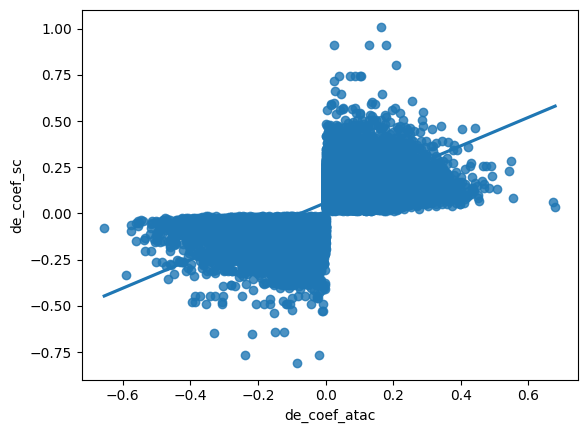

In [71]:
sns.regplot(data=df_degdar, x='de_coef_atac', y='de_coef_sc')

In [48]:
 df_degdar[df_degdar.ctname == "PFC_GABA"]

,names,tx_atac,de_coef_atac,de_se_atac,de_pval_atac,dv_coef_atac,dv_se_atac,dv_pval_atac,ctname,region_atac,...,tx_sc,de_coef_sc,de_se_sc,de_pval_sc,dv_coef_sc,dv_se_sc,dv_pval_sc,de_pval_adj_sc,gender,region_sc
587,chrX:143482812-143483313,stim,0.673005,0.087750,2.760158e-14,-1.013026,0.389300,0.006704,PFC_GABA,PFC,...,stim,0.063625,0.026470,2.147838e-02,0.072768,0.083900,0.467812,5.636378e-02,M,PFC
588,chr18:40308019-40308520,stim,0.441526,0.067975,7.571399e-11,0.304833,0.181202,0.095487,PFC_GABA,PFC,...,stim,0.165686,0.026442,1.232034e-09,-0.156156,0.058654,0.006561,2.899554e-08,M,PFC
589,chr17:39845723-39846224,stim,0.220082,0.037110,3.284569e-09,-0.208376,0.198843,0.301715,PFC_GABA,PFC,...,stim,0.177649,0.056193,1.726630e-03,-0.131046,0.232303,0.499624,7.307664e-03,M,PFC
590,chr17:39845182-39845683,stim,0.219792,0.037541,4.389404e-09,-0.153127,0.156665,0.355397,PFC_GABA,PFC,...,stim,0.177649,0.056193,1.726630e-03,-0.131046,0.232303,0.499624,7.307664e-03,M,PFC
591,chr17:39844552-39845053,stim,0.166089,0.035354,3.173905e-06,-0.335471,0.151907,0.026268,PFC_GABA,PFC,...,stim,0.177649,0.056193,1.726630e-03,-0.131046,0.232303,0.499624,7.307664e-03,M,PFC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2843,chr12:101975197-101975698,stim,-0.012335,0.098906,8.923811e-01,0.120083,0.358877,0.719716,PFC_GABA,PFC,...,stim,-0.225116,0.045877,5.613412e-07,0.434782,0.210698,0.041398,7.408430e-06,M,PFC
2844,chr8:33599297-33599798,stim,-0.007616,0.065246,9.101839e-01,-0.002523,0.269938,0.964816,PFC_GABA,PFC,...,stim,-0.170927,0.092092,4.978218e-02,-0.402121,0.164902,0.010206,1.103365e-01,M,PFC
2845,chr4:48473219-48473720,stim,-0.005165,0.066585,9.118422e-01,0.239677,0.297418,0.400777,PFC_GABA,PFC,...,stim,-0.091630,0.045782,4.072020e-02,0.208928,0.195491,0.396170,9.394270e-02,M,PFC
2846,chr8:105622285-105622786,stim,-0.007008,0.061575,9.235331e-01,0.133083,0.231768,0.494005,PFC_GABA,PFC,...,stim,-0.097710,0.046599,2.588300e-02,0.050529,0.155680,0.908955,6.541373e-02,M,PFC


In [52]:
df_degdar.loc[:,['de_coef_atac','de_coef_sc']].corr()

,de_coef_atac,de_coef_sc
de_coef_atac,1.000000,0.657879
de_coef_sc,0.657879,1.000000


In [53]:
df_degdar_ht.loc[:,['de_coef_atac','de_coef_sc']].corr()

,de_coef_atac,de_coef_sc
de_coef_atac,1.000000,0.772689
de_coef_sc,0.772689,1.000000


In [116]:
df_degdar.loc[df_degdar.region_atac=='AMY',['de_coef_atac','de_coef_sc']].corr()

,de_coef_atac,de_coef_sc
de_coef_atac,1.000000,0.656971
de_coef_sc,0.656971,1.000000


In [125]:
df_degdar_ht.loc[df_degdar_ht.region_atac=='AMY',['de_coef_atac','de_coef_sc']].corr()

,de_coef_atac,de_coef_sc
de_coef_atac,1.000000,0.746445
de_coef_sc,0.746445,1.000000


In [120]:
df_degdar_ht.loc[df_degdar_ht.region_atac=='HIP',['de_coef_atac','de_coef_sc']].corr()

,de_coef_atac,de_coef_sc
de_coef_atac,1.00000,0.54248
de_coef_sc,0.54248,1.00000


In [90]:
df_degdar_ht.corr(method='pearson')

/tmp/ipykernel_1286213/2482177840.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_degdar_ht.corr(method='pearson')


,de_coef_atac,de_se_atac,de_pval_atac,dv_coef_atac,dv_se_atac,dv_pval_atac,gstart,gend,distance,de_coef_sc,de_se_sc,de_pval_sc,dv_coef_sc,dv_se_sc,dv_pval_sc,de_pval_adj
de_coef_atac,1.000000,0.565833,-0.318975,0.110364,0.521352,-0.016617,-0.011157,-0.010662,0.001716,0.319297,0.245404,0.056605,0.040153,0.276262,0.034563,0.103237
de_se_atac,0.565833,1.000000,0.163610,0.139360,0.911770,0.013806,0.011124,0.011539,0.004586,0.263648,0.519274,0.139730,0.039270,0.545001,0.051702,0.242805
de_pval_atac,-0.318975,0.163610,1.000000,-0.001141,0.164126,0.014117,0.013575,0.013426,0.003781,0.040239,0.150436,0.032452,-0.007021,0.144149,-0.007498,0.061421
dv_coef_atac,0.110364,0.139360,-0.001141,1.000000,0.032525,-0.077513,0.005853,0.006159,0.008714,0.050776,0.022664,-0.005842,-0.001120,0.022149,-0.009285,0.002060
dv_se_atac,0.521352,0.911770,0.164126,0.032525,1.000000,0.033052,0.011878,0.011918,0.002459,0.298931,0.600044,0.166003,0.020516,0.653858,0.074910,0.281052
dv_pval_atac,-0.016617,0.013806,0.014117,-0.077513,0.033052,1.000000,-0.005825,-0.005936,0.000670,0.028348,0.031556,0.007761,-0.002904,0.044271,0.005805,0.017305
gstart,-0.011157,0.011124,0.013575,0.005853,0.011878,-0.005825,1.000000,0.999970,0.011087,0.022685,0.020429,0.015019,-0.004343,0.028938,0.009636,0.012857
gend,-0.010662,0.011539,0.013426,0.006159,0.011918,-0.005936,0.999970,1.000000,0.011205,0.022051,0.018415,0.014344,-0.004494,0.027140,0.008388,0.012193
distance,0.001716,0.004586,0.003781,0.008714,0.002459,0.000670,0.011087,0.011205,1.000000,-0.004690,-0.007876,-0.006620,-0.005155,-0.008685,-0.004975,-0.006599
de_coef_sc,0.319297,0.263648,0.040239,0.050776,0.298931,0.028348,0.022685,0.022051,-0.004690,1.000000,0.452981,-0.177102,0.061787,0.383606,0.021178,-0.128718


In [88]:
df_degdar.corr(method='pearson')

/tmp/ipykernel_1286213/1646517094.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_degdar.corr(method='pearson')


,de_coef_atac,de_se_atac,de_pval_atac,dv_coef_atac,dv_se_atac,dv_pval_atac,gstart,gend,distance,de_coef_sc,de_se_sc,de_pval_sc,dv_coef_sc,dv_se_sc,dv_pval_sc,de_pval_adj
de_coef_atac,1.000000,0.403351,0.234119,0.223262,0.450956,0.016874,0.031846,0.031132,0.000455,0.773789,0.230502,0.008499,-0.138771,0.221637,0.103319,0.043538
de_se_atac,0.403351,1.000000,0.331881,0.164879,0.913978,-0.009592,0.030013,0.030359,-0.002579,0.251545,0.479463,0.095063,-0.017120,0.497508,0.047217,0.205903
de_pval_atac,0.234119,0.331881,1.000000,0.052265,0.329997,0.018078,0.016089,0.015921,-0.020004,0.224271,0.149081,-0.001189,-0.031800,0.144520,0.036642,0.025772
dv_coef_atac,0.223262,0.164879,0.052265,1.000000,0.138509,-0.076850,0.022598,0.022477,0.014662,0.157983,0.056181,-0.002555,-0.030917,0.059751,0.018695,0.007296
dv_se_atac,0.450956,0.913978,0.329997,0.138509,1.000000,0.008297,0.025486,0.025439,-0.005572,0.308551,0.546858,0.110696,-0.038288,0.591626,0.080220,0.226365
dv_pval_atac,0.016874,-0.009592,0.018078,-0.076850,0.008297,1.000000,-0.009100,-0.009177,0.001463,0.019889,0.011227,-0.006424,0.006351,0.015718,0.006434,-0.004236
gstart,0.031846,0.030013,0.016089,0.022598,0.025486,-0.009100,1.000000,0.999977,-0.018379,0.029763,0.027635,0.005220,0.017887,0.028069,0.011455,0.004104
gend,0.031132,0.030359,0.015921,0.022477,0.025439,-0.009177,0.999977,1.000000,-0.018282,0.029320,0.025759,0.004697,0.018362,0.026231,0.010126,0.003610
distance,0.000455,-0.002579,-0.020004,0.014662,-0.005572,0.001463,-0.018379,-0.018282,1.000000,0.017709,-0.025553,-0.010769,-0.013762,-0.014898,-0.011585,-0.009377
de_coef_sc,0.773789,0.251545,0.224271,0.157983,0.308551,0.019889,0.029763,0.029320,0.017709,1.000000,0.189370,-0.073710,-0.072705,0.165496,0.059960,-0.061202


In [ ]:
sns.countplot(data=df_degdar, y='ctname', hue='condition', palette=['#FF7F0E','#1F77B4'],hue_order=['MW','MC'])


In [ ]:
df_degdar['coefsq'] = df_degdar['de_coef_atac']*df_degdar['de_coef_sc']

In [ ]:
df_degdar.sort_values(by=['coefsq']).to_csv('/data2st1/junyi/output/atac0416/dar/region_nt/df_degdar.csv',index=False)

In [ ]:
out_dir ='/data2st1/junyi/output/atac0416/dar/motif/region_nt'
for ct in df_inner['ctname'].unique():
    for condition in df_inner['condition'].unique():
        df_sub = df_inner[(df_inner['ctname'] == ct) & (df_inner['condition'] == condition)]
        if len(df_sub) == 0:
            continue
        df_sub["names"].str.split(r'[:-]', expand=True).to_csv(f'{out_dir}/{ct}_{condition}_inner.bed', sep='\t', header=False, index=False)


In [ ]:
out_dir ='/data2st1/junyi/output/atac0416/dar/motif/region_nt'
for ct in df_DAR_mememto['ctname'].unique():
    for condition in df_inner['condition'].unique():
        df_sub = df_inner[(df_inner['ctname'] == ct) & (df_inner['condition'] == condition)]
        if len(df_sub) == 0:
            continue
        df_sub["names"].str.split(r'[:-]', expand=True).to_csv(f'{out_dir}/{ct}_{condition}_memento.bed', sep='\t', header=False, index=False)


In [ ]:
files = glob.glob('/data2st1/junyi/output/atac0416/dar/motif/region_nt/*_inner.bed')
for filename in files:
    command_str = ['pycistarget','cistarget','--cistarget_db_fname','/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather'
                   ,'--bed_fname',filename,'--species','mus_musculus','--auc_threshold','0.005','--nes_threshold','3.0','--rank_threshold','0.05'
                   ,'--path_to_motif_annotations','/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl'
                   ,'--output_folder','/data2st1/junyi/output/atac0416/dar/motif/region_nt/','--write_html']
    print(command_str)
    subprocess.run(command_str)

In [ ]:
files = glob.glob('/data2st1/junyi/output/atac0416/dar/motif/region_nt/*_memento.bed')
for filename in files:
    command_str = ['pycistarget','cistarget','--cistarget_db_fname','/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather'
                   ,'--bed_fname',filename,'--species','mus_musculus','--auc_threshold','0.005','--nes_threshold','3.0','--rank_threshold','0.05'
                   ,'--path_to_motif_annotations','/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl'
                   ,'--output_folder','/data2st1/junyi/output/atac0416/dar/motif/region_nt/','--write_html']
    print(command_str)
    subprocess.run(command_str)

In [ ]:
ax = sns.countplot(data=df_DAR_mememto, x='ctname', hue='condition', dodge=False, palette='Set2',)
plt.ylim(0, 5000)


In [ ]:
for ct in df_inner['ctname'].unique():
    for condition in df_inner['condition'].unique():
        try:
            flist = glob.glob(f'/data2st1/junyi/output/atac0416/dar/motif/region_nt/*{ct}*{condition}*_inner.hdf5')
            df_report = utils.conclude_pycistargets(flist)  
            df_report_annotation = utils.annotate_region(df_report,region_col='region', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')
            df_report_annotation.to_csv(f'/data2st1/junyi/output/atac0416/dar/motif/region_nt/{ct}_{condition}_inner_region_TF.csv', index=False)
        except Exception as e:
            print(f"Error processing {ct} and {condition}: {e}")


In [ ]:
df_join_all_TFs = pd.DataFrame()
for ct in df_DAR_mememto['ctname'].unique():
    for condition in df_DAR_mememto['condition'].unique():
        try:
            #flist = glob.glob(f'/data2st1/junyi/output/atac0416/dar/motif/region_nt/*{ct}*{condition}*_memento.hdf5')
            #df_report = utils.conclude_pycistargets(flist)  
            #df_report_annotation = utils.annotate_region(df_report,region_col='region', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')
            #df_report.to_csv(f'/data2st1/junyi/output/atac0416/dar/motif/region_nt/{ct}_{condition}_memento_TF.csv', index=False)
            df_test= pd.read_csv(f'/data2st1/junyi/output/atac0416/dar/motif/region_nt/{ct}_{condition}_memento_TF.csv')
            df_test['TFs'] = df_test['TFs'].str.replace(r'["\'}{}]|,?\s*nan\s*,?', '', regex=True).str.replace(r' ', '', regex=True).str.strip(",")
            df_join_TFs=df_test[['region','TFs']].groupby(['region']).aggregate(
                lambda x: "/".join(                        # Join aggregated values with '/'
                    sorted(
                        set(                                          # Keep unique values
                            item for sublist in x.str.split(",")      # Split each string by '.'
                            for item in sublist                       # Flatten the split lists
                        )# Remove empty strings
                    )
                )
            ).reset_index()
            df_join_TFs["TFs"]=df_join_TFs.TFs.str.strip('/')

            df_join_TFs["motifs"]=df_test[['region','motif']].groupby(['region']).aggregate(
                lambda x:'/'.join(x)
            ).reset_index()["motif"]
            df_join_TFs["ctname"]="_".join(df_test.key[0].split('_')[:2])
            df_join_TFs["condition"] = df_test.key[0].split('_')[2]
            df_join_TFs["method"] = df_test.key[0].split('_')[3]
            df_join_all_TFs = pd.concat([df_join_all_TFs, df_join_TFs], axis=0, ignore_index=True)
            #df_join_TFs.to_csv(f'/data2st1/junyi/output/atac0416/dar/motif/region_nt/{ct}_{condition}_memento_TF_join.csv', index=False)


        except Exception as e:
            print(f"Error processing {ct} and {condition}: {e}")


In [ ]:
df_join_all_TFs

In [ ]:
df_annotated_TFs = utils.annotate_region(df_join_all_TFs,region_col='region', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')

In [ ]:
df_annotated_TFs['brain_region'] = df_annotated_TFs['ctname'].str.split(r'[_]').str[0]

In [ ]:
df_annotated_TFs.to_csv(f'/data2st1/junyi/output/atac0416/dar/motif/region_nt/motif_memento_TFs.csv', index=False)

In [ ]:
for filename in files:
    df_dar  = pd.read_csv(filename,index_col=0)
    experimentname = re.split(r'[./]', filename)[-2]
    experimentname
    folder_name = os.path.dirname(filename)
    df_dar_filtered = df_dar[(df_dar['pvals']<0.05) & (df_dar['logfoldchanges']>0) ]
    df_dar_filtered.sort_values(by='logfoldchanges',ascending=False,inplace=True)
    # For liftover

    temp_df = df_dar_filtered.names.str.split(r'[ ,!\-;:|]',expand=True)
    temp_df['ID'] = temp_df.index
    temp_df.to_csv(f"{folder_name}/{experimentname}_DAR.bed",header=False,index=False,sep="\t")

In [ ]:
# import subprocess
# files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR.bed')
# for filename in files:
#     experimentname = re.split(r'[./]', filename)[-2]
#     folder_name = os.path.dirname(filename)

#     #!/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_unmap.bed

#     command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz {folder_name}/{experimentname}_lifted.bed {folder_name}/{experimentname}_unmap.bed"
#     print(command_str)
#     subprocess.run(command_str, shell=True)

In [ ]:
import subprocess

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR_lifted.bed')
for filename in files:
    destname = filename.replace("_lifted.bed","_lifted_sorted.bed")
    #!sort -k1,1 -k2,2n {filename} > {destname}
    command_str = f"sort -k1,1 -k2,2n {filename} > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)

In [ ]:
# !sort -k1,1 -k2,2n /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed

In [ ]:
# !sort -k1,1 -k2,2n /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted.bed > /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed

In [ ]:
# !bedtools closest -a /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_gene.bed

In [ ]:
# !bedtools closest -a /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/HIP_Neuron_MC_wilcoxon_DAR_gene.bed

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR_lifted.bed')
for filename in files:
    command_str = ['pycistarget','cistarget','--cistarget_db_fname','/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather'
                   ,'--bed_fname',filename,'--species','mus_musculus','--auc_threshold','0.005','--nes_threshold','3.0','--rank_threshold','0.05'
                   ,'--path_to_motif_annotations','/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl'
                   ,'--output_folder','/data2st1/junyi/output/motif/','--write_html']
    print(command_str)
    subprocess.run(command_str)
    
# !pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
# --bed_fname '/data2st1/junyi/output/motif/AMY_Neuron_MC_wilcoxon_DAR_lifted.bed' \
# --species 'mus_musculus' \
# --auc_threshold 0.005 \
# --nes_threshold 3.0 \
# --rank_threshold 0.05 \
# --path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
# --output_folder '/data2st1/junyi/output/motif/' \
# --write_html 

In [ ]:
import h5py
dict_table = {}
cell_types = ['Neuron','Astro-Epen','Vascular','Immune','OPC-Oligo']
for celltype in cell_types:
    with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_ALL_{celltype}_wilcoxon_DAR_lifted.hdf5', 'r') as f:
        # Open the HDF5 file
        # List all groups and datasets in the file
        print("Keys in the file:", list(f.keys()))
        

        # # Access a specific dataset
        expname = f'ALL_{celltype}_wilcoxon_DAR_lifted'
        dataset = f[expname]  # Replace with your dataset name
        # print("Shape of the dataset:", dataset.shape)
        # print("Data type of the dataset:", dataset.dtype)
        dict_dataset = {}
        #region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][0:10]

        table = f[expname]['motif_enrichment']['table'][:]
        for key in dataset.keys():
            dict_dataset[key] = dataset[key]
        # print("Data:", data)
        dict_table[expname] = table

In [ ]:
for keys in dict_table.keys():
    print(keys)
    print(dict_table[keys][:5])
    #Astro : id, orthology, direcrt, id, msimilarity,logo
    #Neuron : id,logo,orthology, id, direct, msimilarity
    #Vascular : id,logo,orthology,msimilarity,id, direct

In [ ]:
list_table = []
list_key = []
list_TFs = []

df_TF_celltype = pd.DataFrame()

for key in dict_table.keys():
    data = dict_table[key]
    for row in data:
        list_table.append(row[0].decode('utf-8'))
        list_key.append(key)
        TFs_tmp=[]
        for i in range(1, len(row)-2):
            if 'img' in row[i][0].decode('utf-8') or 'wilcoxon' in row[i][0].decode('utf-8'):
                continue
            TFs_tmp+=([ tf.decode('utf-8') for tf in row[i]])

        df_tfs = pd.DataFrame({'TF':",".join(TFs_tmp).split(',')})
        df_tfs['NES'] = row[-2][0]
        df_tfs['AUC'] = row[-2][1]
        df_tfs['Rank'] = row[-2][2]
        df_tfs['celltype.L1'] = key.split('_')[1]
        df_tfs['id'] = row[0].decode('utf-8')

        list_TFs.append(set(TFs_tmp))
        df_TF_celltype = pd.concat([df_TF_celltype,df_tfs],axis=0)
        
df_TF = pd.DataFrame({'TF':list_table,'key':list_key,'TFs':list_TFs})

In [ ]:
df_TF_celltype.drop_duplicates(inplace=True)


In [ ]:
df_TF_celltype

In [ ]:
df_RSS = pd.read_csv("/home/junyichen/code/scmmd/data/RSS_Score(only pos).csv",index_col=0)

In [ ]:
df_RSS['TF']=df_RSS['Topic'].str.replace('[()+]','')

In [ ]:
cell_to_category = {
    # Astro-Epen
    'Astro-Gfaphigh': 'Astro-Epen',
    'Astro-TE': 'Astro-Epen',
    
    # Immune
    'Microglia': 'Immune',
    'PVM': 'Immune',
    
    # Neuron
    'L2/3 IT': 'Neuron',
    'L4/5 IT': 'Neuron',
    'L5 ET': 'Neuron',
    'L6 CT': 'Neuron',
    'L6 IT': 'Neuron',
    'L6b': 'Neuron',
    'Lamp5 GABA': 'Neuron',
    'Pvalb GABA': 'Neuron',
    'Pvalb Vipr2 GABA': 'Neuron',
    'Sst GABA': 'Neuron',
    'Vip GABA': 'Neuron',
    
    # OPC-Oligo
    'COP': 'OPC-Oligo',
    'MFOL': 'OPC-Oligo',
    'MOL': 'OPC-Oligo',
    'NFOL': 'OPC-Oligo',
    'NP': 'OPC-Oligo',
    'OPC': 'OPC-Oligo',
    
    # Vascular
    'Arachnoid barrier cell': 'Vascular',
    'Car3': 'Vascular',
    'Endothelial cell': 'Vascular',
    'Pericyte': 'Vascular',
    'VLMC': 'Vascular'
}

In [ ]:
df_RSS['celltype.L1'] = df_RSS['celltype.L2'].map(cell_to_category)


In [ ]:
df_TF_celltype.groupby(['celltype.L1']).nunique()

In [ ]:
df_RSS.groupby(['celltype.L1']).nunique()

In [ ]:
df_merged = df_RSS.merge(df_TF_celltype,left_on=['TF','celltype.L1'],right_on=['TF','celltype.L1'],how='inner')

In [ ]:
df_merged.sort_values(by='RSS',ascending=False,inplace=True)

In [ ]:
df_merged.drop_duplicates(set(['TF','celltype.L1']),keep='first').to_csv('/data2st1/junyi/output/motif/TF_RSS.csv',index=False)

In [ ]:
df_merged.groupby('celltype.L1').nunique()

In [ ]:
ct = pd.crosstab(df_merged['celltype'],df_merged['celltype.L1'],values=df_merged['RSS'],aggfunc='count')

In [ ]:
ct

In [ ]:
set(df_merged['celltype']
)

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/ALL_*_wilcoxon_DAR_lifted_sorted.bed')
for filename in files:
    destname = filename.replace("_lifted_sorted.bed","_lifted_sorted_gene.bed")
    command_str = f"bedtools closest -a {filename} -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)
# !bedtools closest -a /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_lifted_sorted.bed -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > /data2st1/junyi/output/motif/PFC_Neuron_MC_wilcoxon_DAR_gene.bed

In [ ]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/AMY_Neuron_MC_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html 

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon.csv')
for filename in files:
    df_dar  = pd.read_csv(filename,index_col=0)
    experimentname = re.split(r'[./]', filename)[-2]
    experimentname
    folder_name = os.path.dirname(filename)
    df_dar_filtered = df_dar[(df_dar['pvals']<0.05) & (df_dar['logfoldchanges']>0) ]
    df_dar_filtered.sort_values(by='logfoldchanges',ascending=False,inplace=True)
    # For liftover
    df_dar_filtered.names.str.split(r'[ ,!\-;:|]',expand=True).to_csv(f"{folder_name}/{experimentname}_DAR.bed",header=False,index=False,sep="\t")

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR.bed')
for filename in files:
    experimentname = re.split(r'[./]', filename)[-2]
    folder_name = os.path.dirname(filename)

    #!/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_unmap.bed

    command_str = f"/home/junyichen/liftOver {filename} /data2st1/junyi/mm39ToMm10.over.chain.gz {folder_name}/{experimentname}_lifted.bed {folder_name}/{experimentname}_unmap.bed"
    print(command_str)
    subprocess.run(command_str, shell=True)

In [ ]:
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR_lifted.bed')
for filename in files:
    destname = filename.replace("_lifted.bed","_lifted_sorted.bed")
    #!sort -k1,1 -k2,2n {filename} > {destname}
    command_str = f"sort -k1,1 -k2,2n {filename} > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR_lifted_sorted.bed')
for filename in files:
    destname = filename.replace("_lifted_sorted.bed","_lifted_sorted_gene.bed")
    command_str = f"bedtools closest -a {filename} -b /data2st1/junyi/output/motif/genebody_selected_sorted.bed -D ref > {destname}"
    print(command_str)
    subprocess.run(command_str, shell=True)

In [ ]:
# from pyliftover import LiftOver
# lo = LiftOver('/data2st1/junyi/mm10ToMm39.over.chain.gz')
# lo.convert_coordinate('chr1', 1000000, '-')


In [ ]:
result_frame = pd.DataFrame()
files = glob.glob('/data2st1/junyi/output/motif/*MW*wilcoxon_DAR_lifted_sorted_gene.bed')
for filename in files:
    experimentname = re.split(r'[./]', filename)[-2]
    region = re.split(r'_',experimentname)[0]
    celltype = re.split(r'_',experimentname)[1]
    condition = re.split(r'_',experimentname)[2]
    try:
        df = pd.read_csv(filename,sep='\t',header=None)
    except:
        continue
    df.columns = ['chrom','start','end','chrom2','start2','end2','score','starnd','gene_name','gene_id','annotation','distance']
    df['region'] = region
    df['celltype'] = celltype
    df['condition'] = condition
    df['name'] = df['chrom'] + ':' + df['start'].astype(str) + '-' + df['end'].astype(str)
    # df_score = pd.read_csv(f"/data2st1/junyi/output/motif/{region}_{celltype}_{condition}_wilcoxon.csv",index_col=0)
    # df['logfoldchanges'] = df_score.set_index('names').loc[df['name'],'logfoldchanges'].values
    # df['pvals'] = df_score.set_index('names').loc[df['name'],'pvals'].values
    result_frame = pd.concat([result_frame,df])

In [ ]:
ax = sns.countplot(data=result_frame, x='celltype', hue='region', dodge=False, palette='Set2',)
ax.set_ylim(0,6000)


In [ ]:
keep1=result_frame.sort_values(by='starnd',ascending=True).drop_duplicates(subset=['chrom','start','end'])
keep1['generegion'] = 'genebody'
#keep1.loc[keep1['distance']<0,'generegion'] = 'downstream'
promoter = keep1.loc[(keep1['distance']>0) & (keep1['distance']<=2000) & (keep1['starnd']=='+')].index
distal = keep1.loc[(keep1['distance']>0) & (keep1['distance']>=2000) & (keep1['starnd']=='+')].index
keep1.loc[promoter,'generegion'] = 'promoter'
keep1.loc[distal,'generegion'] = 'distal'

promoter = keep1.loc[(keep1['distance']<0) & (keep1['distance']>=-2000) & (keep1['starnd']=='-')].index
distal = keep1.loc[(keep1['distance']<0) & (keep1['distance']<=-2000) & (keep1['starnd']=='-')].index
keep1.loc[promoter,'generegion'] = 'promoter'
keep1.loc[distal,'generegion'] = 'distal'


In [ ]:
keep1=keep1.loc[keep1['start2']>0]

In [ ]:
keep1.sort_values(by='starnd',ascending=True).drop_duplicates(subset=['chrom','start','end'])

In [ ]:
ax = sns.countplot(data=keep1, x='celltype', hue='generegion', dodge=False, palette='Set2',)

In [ ]:
pd.read_csv('/data2st1/junyi/output/motif/AMY_Neuron_MC_wilcoxon.csv',index_col=0)

In [ ]:
# Convert hg38 to hg19
# !/home/junyichen/liftOver /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_unmap.bed
# !/home/junyichen/liftOver /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_unmap.bed
# !/home/junyichen/liftOver /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR.bed /data2st1/junyi/mm39ToMm10.over.chain.gz /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_lifted.bed /data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_unmap.bed


In [ ]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/HIP_Neuron_MW_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html

In [ ]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/AMY_Neuron_MW_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html

In [ ]:
!pycistarget cistarget --cistarget_db_fname '/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather' \
--bed_fname '/data2st1/junyi/output/motif/PFC_Neuron_MW_wilcoxon_DAR_lifted.bed' \
--species 'mus_musculus' \
--auc_threshold 0.005 \
--nes_threshold 3.0 \
--rank_threshold 0.05 \
--path_to_motif_annotations '/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl' \
--output_folder '/data2st1/junyi/output/motif/' \
--write_html

In [ ]:
import h5py
import copy

regions = ['AMY','HIP','PFC']
celltypes = ['Neuron']

dict_table = {}

for region in regions:
    for celltype in celltypes:
        with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_{region}_{celltype}_MC_wilcoxon_DAR_lifted.hdf5', 'r') as f:
            # Open the HDF5 file
            # List all groups and datasets in the file
            print("Keys in the file:", list(f.keys()))
            

            # # Access a specific dataset
            expname = f'{region}_{celltype}_MC_wilcoxon_DAR_lifted'
            dataset = f[expname]  # Replace with your dataset name
            # print("Shape of the dataset:", dataset.shape)
            # print("Data type of the dataset:", dataset.dtype)

            dict_dataset = {}

            #region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][0:10]

            table = f[expname]['motif_enrichment']['table'][:]
            for key in dataset.keys():
                dict_dataset[key] = dataset[key]
            # print("Data:", data)
            dict_table[expname] = table

In [ ]:
for i in dict_table['AMY_Neuron_MC_wilcoxon_DAR_lifted']:
    print(i[0])

In [ ]:
region_table = {}

for region in regions:
    for celltype in celltypes:
        with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_{region}_{celltype}_MC_wilcoxon_DAR_lifted.hdf5', 'r') as f:
            # Open the HDF5 file
            # List all groups and datasets in the file
            print("Keys in the file:", list(f.keys()))
            

            # # Access a specific dataset
            expname = f'{region}_{celltype}_MC_wilcoxon_DAR_lifted'
            dataset = f[expname]  # Replace with your dataset name
            # print("Shape of the dataset:", dataset.shape)
            # print("Data type of the dataset:", dataset.dtype)

            dict_dataset = {}

            region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][:]
            region_table[expname] = region

In [ ]:
import numpy as np

list_table = []
list_key = []

for key in dict_table.keys():
    data = dict_table[key]
    for row in data:
        list_table.append(row[0])
        list_key.append(key)
df_TF = pd.DataFrame({'TF':list_table,'key':list_key})

In [ ]:
df_TF

In [ ]:
df_count = df_TF.groupby('TF').count().sort_values(by='key',ascending=False)

In [ ]:
df_count[df_count['key']>2].index

In [ ]:
df_regions = pd.DataFrame()

for region in regions:
    for celltype in celltypes:
        with h5py.File(f'/data2st1/junyi/output/motif/motif_enrichment_cistarget_{region}_{celltype}_MC_wilcoxon_DAR_lifted.hdf5', 'r') as f:
            # Open the HDF5 file
            # List all groups and datasets in the file
            print("Keys in the file:", list(f.keys()))
            

            # # Access a specific dataset
            expname = f'{region}_{celltype}_MC_wilcoxon_DAR_lifted'
            dataset = f[expname]  # Replace with your dataset name
            # print("Shape of the dataset:", dataset.shape)
            # print("Data type of the dataset:", dataset.dtype)


            for TF in df_count[df_count['key']>2].index:
                region = f[expname]['motif_hits']['region_set'][TF][:]
                decoded_data = [item.decode('utf-8') for item in region]
                df_region = pd.DataFrame(decoded_data,columns=['region'])
                df_region['expreiment'] = expname
                df_region['TF'] = TF.decode('utf-8')
                if len(df_regions)>0:
                    df_regions = pd.concat([df_regions,df_region],axis=0,ignore_index=True)
                else:
                    df_regions = df_region
            #region = f[expname]['motif_hits']['region_set']['metacluster_33.8'][:]
            #region_table[expname] = df_regions

In [ ]:
df_count[df_count['key']>2].index

In [ ]:
df_regions.head(10)

In [ ]:
region_table

In [ ]:
sns.countplot(data=df_TF, x='key', dodge=False, palette='Set2',)
plt.xticks(rotation=60)


In [ ]:
for key in dict_table.keys():
    print(len(dict_table[key]))

In [ ]:
table